In [25]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob
import pandas as pd
import seaborn as sns

## Ground truth - annotation files

In [2]:
import xml.etree.ElementTree as ET

In [3]:
img_dir = "dataset/second_approach/images/"
annot_dir = "dataset/second_approach/annotations/"

In [4]:
annot = [file for file in glob.glob(annot_dir + "*.xml")]

### Let's see exemplary files content

In [5]:
annot1 = [annot[3]]+[annot[1]]
annot1

['dataset/second_approach/annotations/maksssksksss110.xml',
 'dataset/second_approach/annotations/maksssksksss380.xml']

In [6]:
def extract_faces(annotations, return_bdbox=False):
    images = []
    labels = []
    files = []
    for img_annot in annotations:
        tree = ET.parse(img_annot)
        root = tree.getroot()
        file = root.find('filename').text
        file_path = img_dir + file
        img = cv.imread(file_path)
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        x = img.shape[1]/width
        y = img.shape[0]/height
        objects = root.findall('object')
        for object in objects:
            label = object.find('name').text
            place = str(len(objects)) + ": " + label
            labels.append(place)
            bndbox = object.find('bndbox')
            xmin = int((int(bndbox.find('xmin').text))/x)
            ymin = int((int(bndbox.find('ymin').text))/y)
            xmax = int((int(bndbox.find('xmax').text))/x)
            ymax = int((int(bndbox.find('ymax').text))/y)
            if return_bdbox:
                images.append([xmin, ymin, xmax, ymax])
                files.append(file_path)
            else:
                face = img[ymin:ymax, xmin:xmax]
                images.append(face)
    if return_bdbox:
        return images, labels, files
    return images, labels

In [7]:
images1, labels1 = extract_faces(annot1)
len(labels1)

27

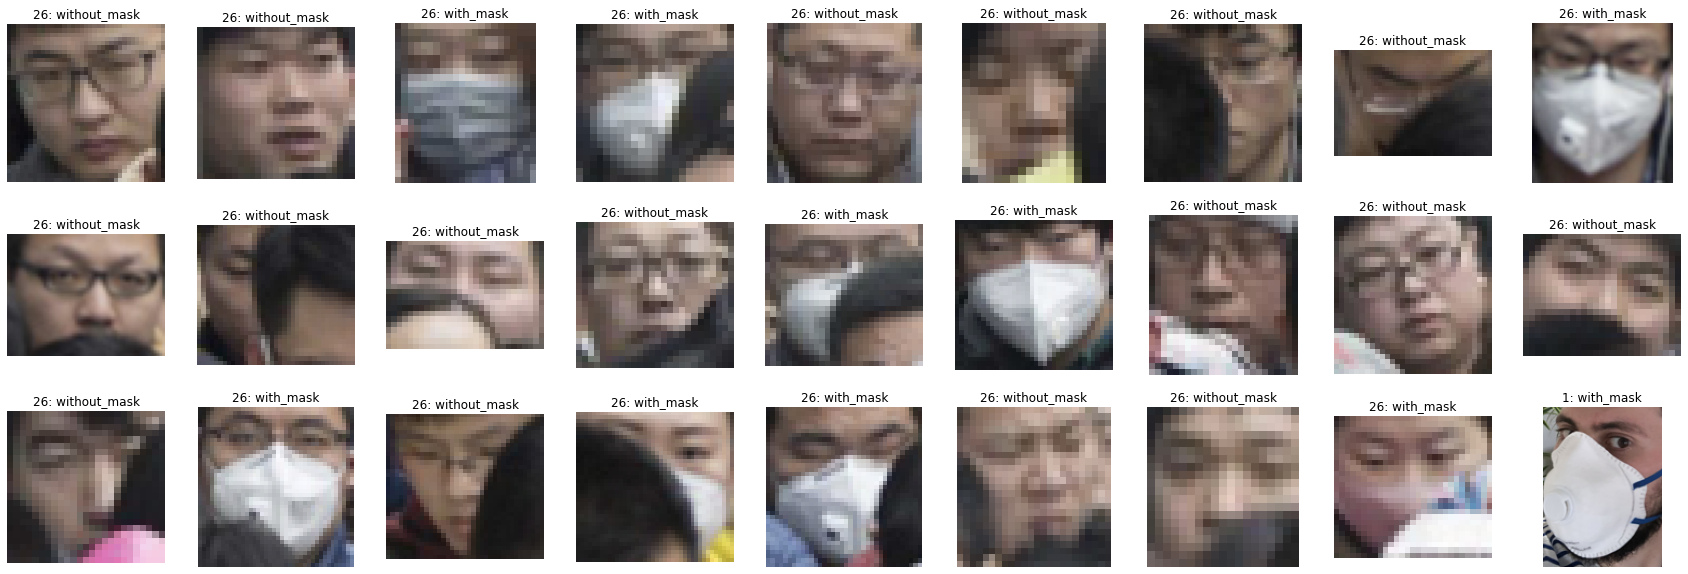

In [8]:
fig=plt.figure(figsize=(30, 10))
axes = []
for i in range(len(images1)):
    img = cv.cvtColor(images1[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(3, 9, i+1))
    plt.axis('off')
    plt.title(labels1[i])
    plt.imshow(img)   
plt.show()

What's good:
- multiple faces at one photo
- ocluded elements
- diffetent positions

## Let's take a closer look at the dataset

In [9]:
faces_on_photo = []
photo_size = []

face_sizes_area = []
face_sizes_perc = []

tiny_faces_annot = []
tiny_faces_img = []

for img_annot in annot:
    tree = ET.parse(img_annot)
    root = tree.getroot()
    objects = root.findall('object')
    faces_number = len(objects)
    file = root.find('filename').text
    file_path = img_dir + file
    img = cv.imread(file_path)
    img_size = img.shape[0]*img.shape[1]
    photo_size.append(img_size)
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    x = img.shape[1]/width
    y = img.shape[0]/height
    for object in objects:
        bndbox = object.find('bndbox')
        xmin = int((int(bndbox.find('xmin').text))/x)
        ymin = int((int(bndbox.find('ymin').text))/y)
        xmax = int((int(bndbox.find('xmax').text))/x)
        ymax = int((int(bndbox.find('ymax').text))/y)
        area = (xmax-xmin)*(ymax-ymin)
        if(area < 16):
            print("Tiny face: ", file, "size: ", area)
            tiny_faces_annot.append(img_annot)
            tiny_faces_img.append(file_path)
            faces_number -= 1
        else:
            face_sizes_area.append(area**(0.5))
            face_sizes_perc.append(100*area/img_size)
    faces_on_photo.append(faces_number)

Tiny face:  maksssksksss64.png size:  6
Tiny face:  maksssksksss64.png size:  9
Tiny face:  maksssksksss64.png size:  2
Tiny face:  maksssksksss64.png size:  4
Tiny face:  maksssksksss64.png size:  6
Tiny face:  maksssksksss64.png size:  2
Tiny face:  maksssksksss64.png size:  2
Tiny face:  maksssksksss486.png size:  12
Tiny face:  maksssksksss603.png size:  15


### Tiny faces?

In [10]:
tiny_faces_annot = list(set(tiny_faces_annot))
tiny_faces_img = list(set(tiny_faces_img))
tiny_faces_annot

['dataset/second_approach/annotations/maksssksksss603.xml',
 'dataset/second_approach/annotations/maksssksksss64.xml',
 'dataset/second_approach/annotations/maksssksksss486.xml']

In [11]:
tiny_faces_img

['dataset/second_approach/images/maksssksksss603.png',
 'dataset/second_approach/images/maksssksksss64.png',
 'dataset/second_approach/images/maksssksksss486.png']

In [ ]:
tiny_faces_img = [tiny_faces_img[i] for i in [0, 2, 1]]
tiny_faces_img

In [12]:
imgs2 = []
for i in tiny_faces_img:
    imgs2.append(cv.imread(i))
images2, labels2, files2 = extract_faces(tiny_faces_annot, return_bdbox=True)
len(labels2)

134

In [48]:
from collections import Counter

In [49]:
Counter(files2)

Counter({'dataset/second_approach/images/maksssksksss603.png': 115,
         'dataset/second_approach/images/maksssksksss64.png': 11,
         'dataset/second_approach/images/maksssksksss486.png': 8})

In [13]:
fig=plt.figure(figsize=(30, 10))
axes = []
for i in range(len(imgs2)):
    img = cv.cvtColor(imgs2[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(1,3, i+1))
    plt.axis('off')
    plt.imshow(img)
plt.show()

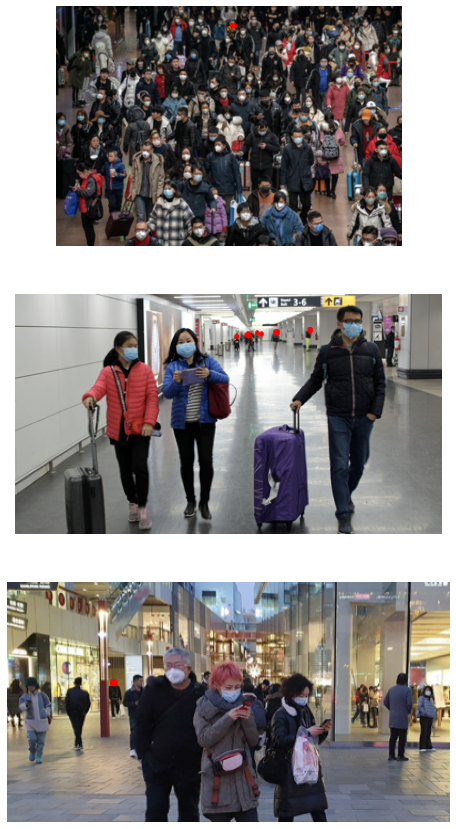

In [14]:
fig=plt.figure(figsize=(10, 15))
axes = []

for i in range(len(images2)):
    bdbox = images2[i]
    if ((bdbox[2]-bdbox[0])*(bdbox[3]-bdbox[1]) < 16):
        idx = tiny_faces_img.index(files2[i])
        cv.rectangle(imgs2[idx], (bdbox[0], bdbox[1]), (bdbox[2], bdbox[3]), (0, 0, 255), 2)
for i in range(len(imgs2)):
    img = cv.cvtColor(imgs2[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(3, 1, i+1))
    plt.axis('off')
    plt.imshow(img) 


### Histograms

In [15]:
photo_size = [x / 10**3 for x in photo_size]
photo_characteristics = pd.DataFrame({'Faces on photo': faces_on_photo, 'Photo size (kilopixels)': photo_size})

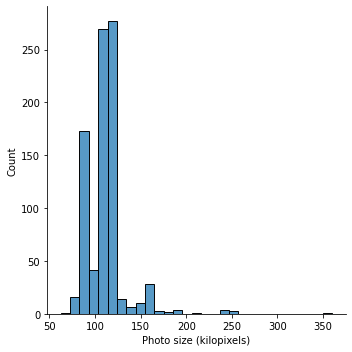

In [17]:
sns.displot(photo_characteristics, x='Photo size (kilopixels)', bins=int((len(photo_characteristics))**(0.5)))

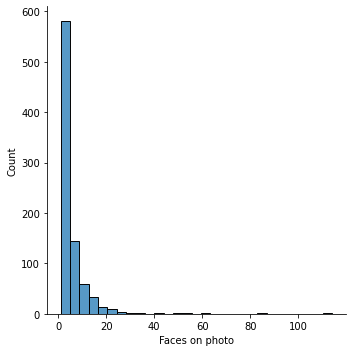

In [18]:
sns.displot(photo_characteristics, x='Faces on photo', bins=int((len(photo_characteristics))**(0.5)))

In [19]:
faces_characteristics = pd.DataFrame({'Faces area': face_sizes_area, 'Faces percentage': face_sizes_perc})

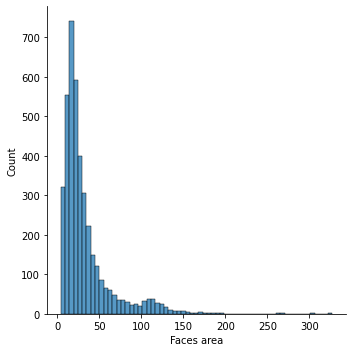

In [62]:
sns.displot(faces_characteristics, x='Faces area', bins=int((len(faces_characteristics))**(0.5)))

In [85]:
import matplotlib.ticker as tkr

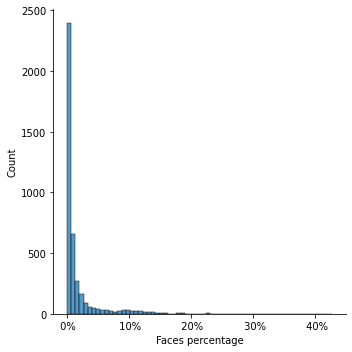

In [91]:
fig = sns.displot(faces_characteristics, x='Faces percentage', bins=int((len(faces_characteristics))**(0.5)))
for ax in fig.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f'{x: .0f}%'))
fig

### Exemplary files - detection check

In [22]:
img_dir = 'dataset/second_approach/images/'
exemplary_annot = ['dataset/second_approach/annotations/maksssksksss521.xml',
                  'dataset/second_approach/annotations/maksssksksss473.xml',
                  'dataset/second_approach/annotations/maksssksksss110.xml']

In [23]:
exemplary_imgs_files = ['dataset/second_approach/images/maksssksksss521.png',
                        'dataset/second_approach/images/maksssksksss473.png',
                        'dataset/second_approach/images/maksssksksss110.png']
exemplary_imgs = [cv.imread(file) for file in exemplary_imgs_files]

In [24]:
exemplary_images, exemplary_labels, exemplary_files = extract_faces(exemplary_annot, return_bdbox=True)

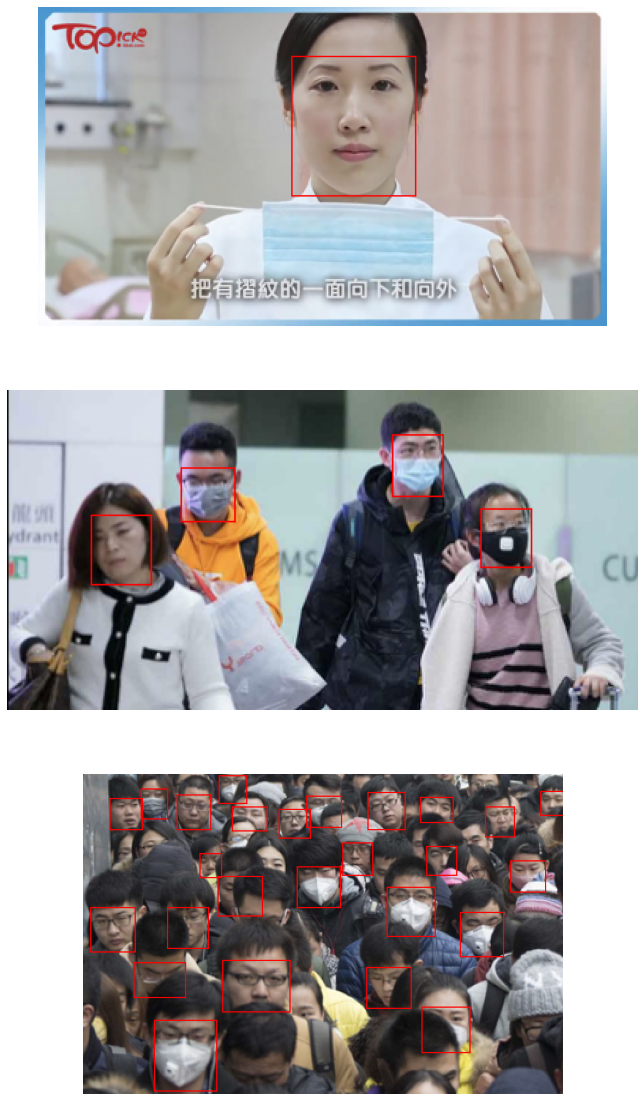

In [92]:
fig=plt.figure(figsize=(30, 20))
axes = []

for i in range(len(exemplary_images)):
    bdbox = exemplary_images[i]
    idx = exemplary_imgs_files.index(exemplary_files[i])
    cv.rectangle(exemplary_imgs[idx], (bdbox[0], bdbox[1]), (bdbox[2], bdbox[3]), (0, 0, 255), 1)
for i in range(len(exemplary_imgs)):
    img = cv.cvtColor(exemplary_imgs[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(3, 1, i+1))
    plt.axis('off')
    plt.imshow(img)

## Detector 1 - OpenCV's Haar Cascades

In [26]:
haar_detector = cv.CascadeClassifier('models/haarcascade_frontalface_default.xml')

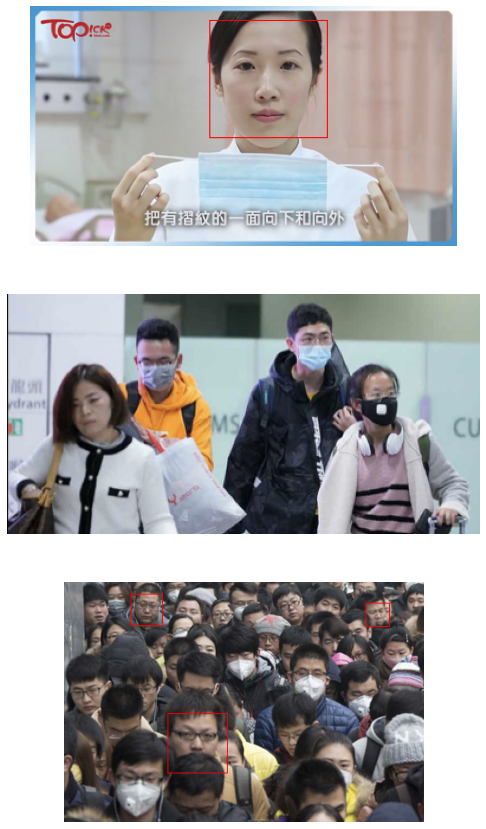

In [93]:
exemplary_imgs = [cv.imread(file) for file in exemplary_imgs_files]
fig=plt.figure(figsize=(30, 15))
axes = []

for i in range(len(exemplary_imgs)):
    img = exemplary_imgs[i]
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = haar_detector.detectMultiScale(img_gray, scaleFactor = 1.2, minNeighbors = 5)
    for (a, b, c, d) in faces:
        cv.rectangle(img, (a, b), (a+c, b+d), (0, 0, 255), 1)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(3, 1, i+1))
    plt.axis('off')
    plt.imshow(img)

In [28]:
def get_haar_results(detector, img):
    haar_faces = detector.detectMultiScale(img, scaleFactor = 1.2, minNeighbors = 5)
    haar_number = len(haar_faces)
    return haar_number

## Detector 2 - OpenCV's DNN module

In [29]:
dnn_detector = cv.dnn.readNetFromCaffe("models/deploy.prototxt.txt",
                                       "models/res10_300x300_ssd_iter_140000.caffemodel")

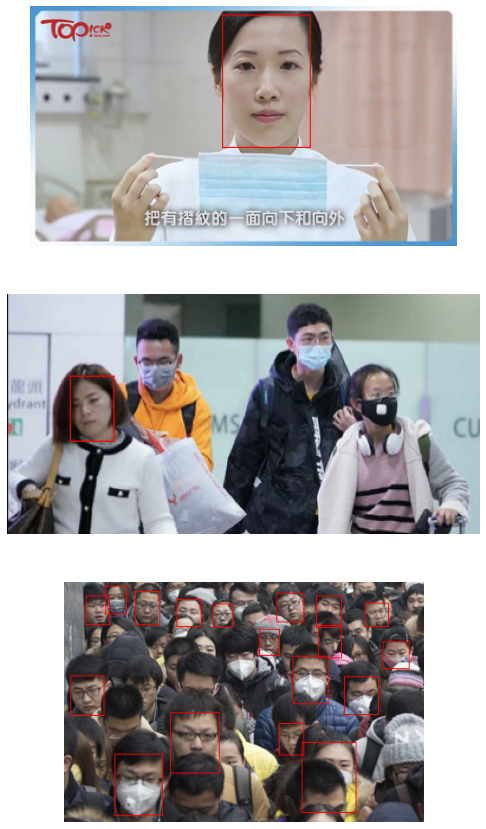

In [94]:
exemplary_imgs = [cv.imread(file) for file in exemplary_imgs_files]
fig=plt.figure(figsize=(30, 15))
axes = []

for i in range(len(exemplary_imgs)):
    img = exemplary_imgs[i]
    h, w = img.shape[:2]
    blob = cv.dnn.blobFromImage(cv.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 117.0, 123.0))
    dnn_detector.setInput(blob)
    detected = dnn_detector.forward()
    for j in range(detected.shape[2]):
        confidence = detected[0, 0, j, 2]
        if confidence > 0.5:
            box = detected[0, 0, j, 3:7] * np.array([w, h, w, h])
            coords = box.astype("int")
            cv.rectangle(img, (coords[0], coords[1]), (coords[2], coords[3]), (0, 0, 255), 1)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(3, 1, i+1))
    plt.axis('off')
    plt.imshow(img)

In [31]:
def get_dnn_results(detector, img):
    blob = cv.dnn.blobFromImage(cv.resize(img, (300, 300)),
                                1.0, (300, 300), (104.0, 117.0, 123.0))
    detector.setInput(blob)
    detected = detector.forward()
    x = 0
    for i in range(detected.shape[2]):
        confidence = detected[0, 0, i, 2]
        if confidence > 0.5:
            x += 1
    return x

## Detector 3 - MTCNN

In [32]:
from mtcnn.mtcnn import MTCNN
mtcnn_detector = MTCNN()

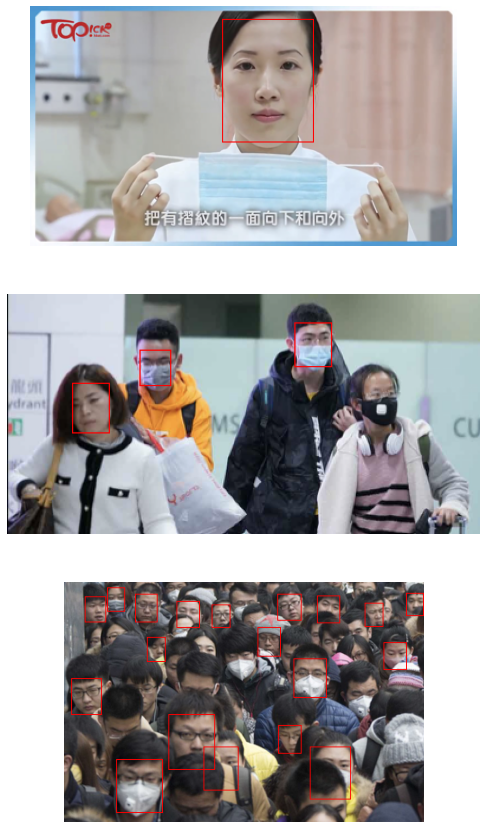

In [95]:
exemplary_imgs = [cv.imread(file) for file in exemplary_imgs_files]
fig=plt.figure(figsize=(30, 15))
axes = []

for i in range(len(exemplary_imgs)):
    img = exemplary_imgs[i]
    faces = mtcnn_detector.detect_faces(img)
    for face in faces:
        bdbox =face.get('box')
        cv.rectangle(img, (bdbox[0], bdbox[1]), (bdbox[0]+bdbox[2], bdbox[1]+bdbox[3]), (0, 0, 255), 1)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(3, 1, i+1))
    plt.axis('off')
    plt.imshow(img)

In [34]:
def get_mtcnn_results(detector, img):
    faces = detector.detect_faces(img)
    return len(faces)

## Detector 4 - Dlib

In [35]:
import dlib
dlib_detector = dlib.get_frontal_face_detector()

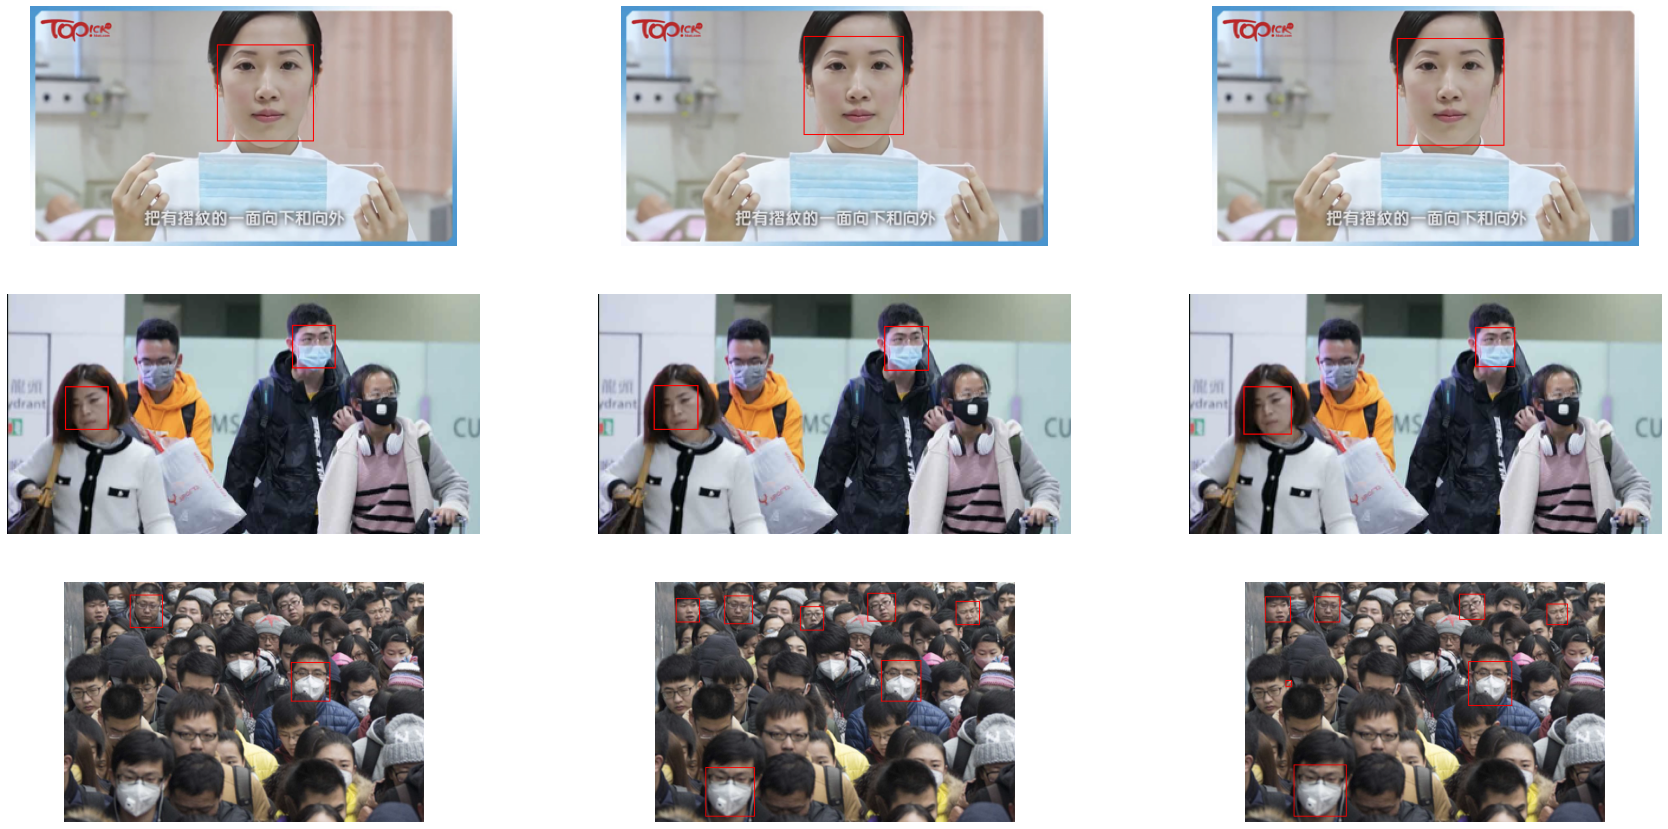

In [101]:
fig=plt.figure(figsize=(30, 15))
axes = []

changing_param = [1, 2, 4]
for j in range(len(changing_param)):
    exemplary_imgs = [cv.imread(file) for file in exemplary_imgs_files]
    for i in range(len(exemplary_imgs)):
        image = exemplary_imgs[i]
        faces = dlib_detector(image, changing_param[j])
        for face in faces:
            cv.rectangle(image, (face.left(), face.top()), (face.right(), face.bottom()), (0, 0, 255), 1)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        axes.append(fig.add_subplot(3, 3, 3*i+j+1))
        plt.axis('off')
        plt.imshow(image)

In [39]:
def get_dlib_results(detector, img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = detector(gray, 4)
    return len(faces)

## Detector 5 - 3DDFA

In [40]:
import importlib

In [41]:
import yaml
import matplotlib.pyplot as plt

FaceBoxes = importlib.import_module('3DDFA_V2.FaceBoxes.FaceBoxes')
mod_TDDFA = importlib.import_module('3DDFA_V2.TDDFA')
TDDFA = getattr(mod_TDDFA, "TDDFA")
mod_functions = importlib.import_module('3DDFA_V2.utils.functions')
draw_landmarks = getattr(mod_functions, "draw_landmarks")
mod_render = importlib.import_module('3DDFA_V2.utils.render')
render = getattr(mod_render, "render")
mod_depth = importlib.import_module('3DDFA_V2.utils.depth')
depth = getattr(mod_depth, "depth")


In [42]:
# load config
cfg = yaml.load(open('3DDFA_V2/configs/mb1_120x120.yml'), Loader=yaml.SafeLoader)

# Init FaceBoxes and TDDFA, recommend using onnx flag
onnx_flag = True  # or True to use ONNX to speed up
if onnx_flag:
    import os
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    os.environ['OMP_NUM_THREADS'] = '4'
    
    mod_FaceBoxesONNX = importlib.import_module('3DDFA_V2.FaceBoxes.FaceBoxes_ONNX')
    FaceBoxes_ONNX = getattr(mod_FaceBoxesONNX, "FaceBoxes_ONNX")
    mod_TDDFA_ONNX = importlib.import_module('3DDFA_V2.TDDFA_ONNX')
    TDDFA_ONNX = getattr(mod_TDDFA_ONNX, "TDDFA_ONNX")
    
    face_boxes = FaceBoxes_ONNX()
    tddfa = TDDFA_ONNX(**cfg)
else:
    tddfa = TDDFA(gpu_mode=False, **cfg)
    face_boxes = FaceBoxes()

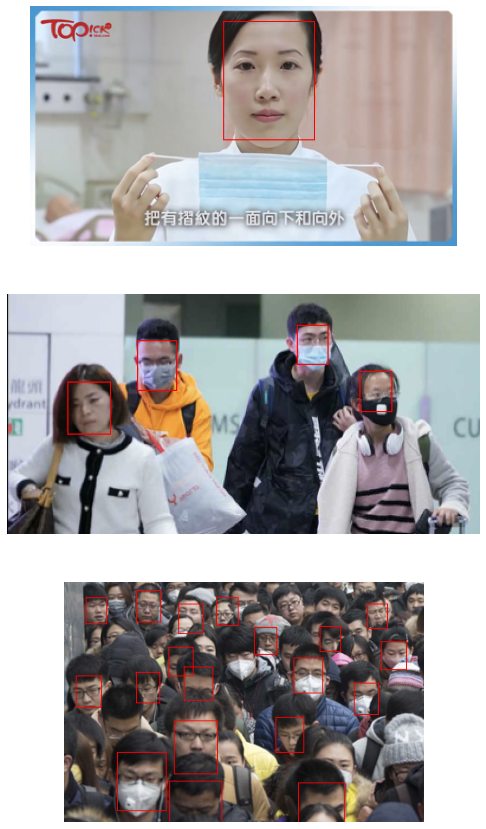

In [102]:
exemplary_imgs = [cv.imread(file) for file in exemplary_imgs_files]
fig=plt.figure(figsize=(30, 15))
axes = []

for i in range(len(exemplary_imgs)):
    img = exemplary_imgs[i]
    boxes = face_boxes(img)
    for box in boxes:
        if box[4] > 0.5:
            cv.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), 1)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(3, 1, i+1))
    plt.axis('off')
    plt.imshow(img)

<Figure size 2160x1080 with 0 Axes>

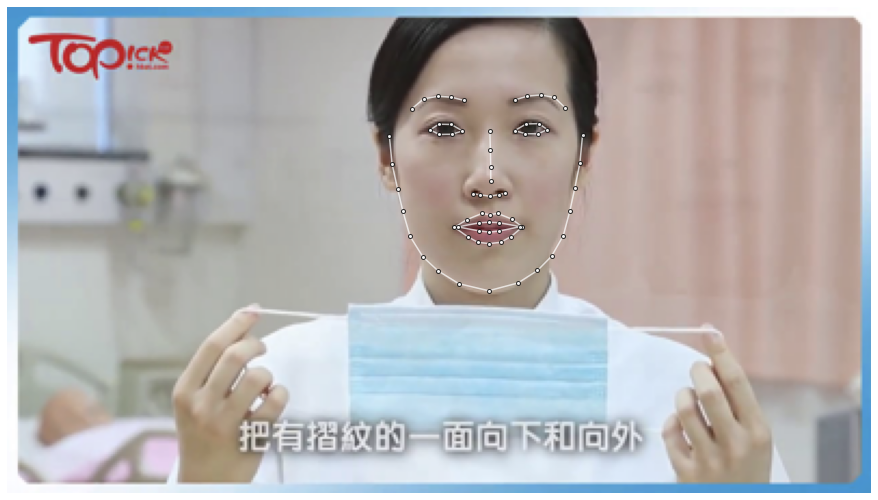

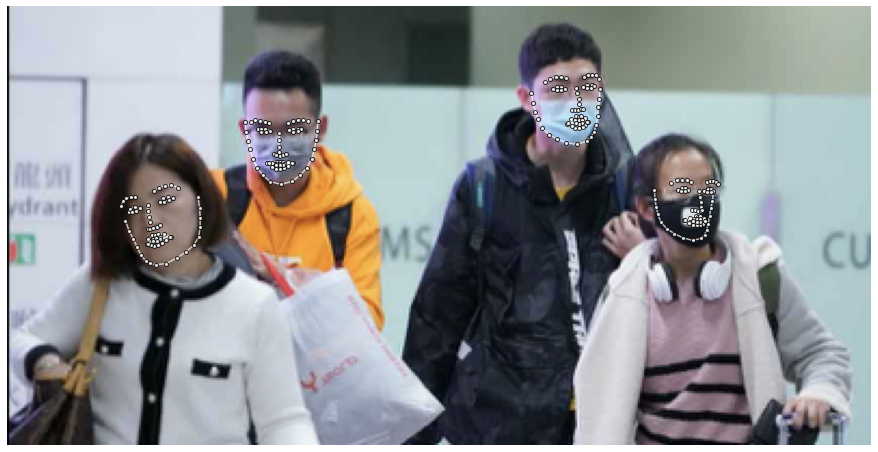

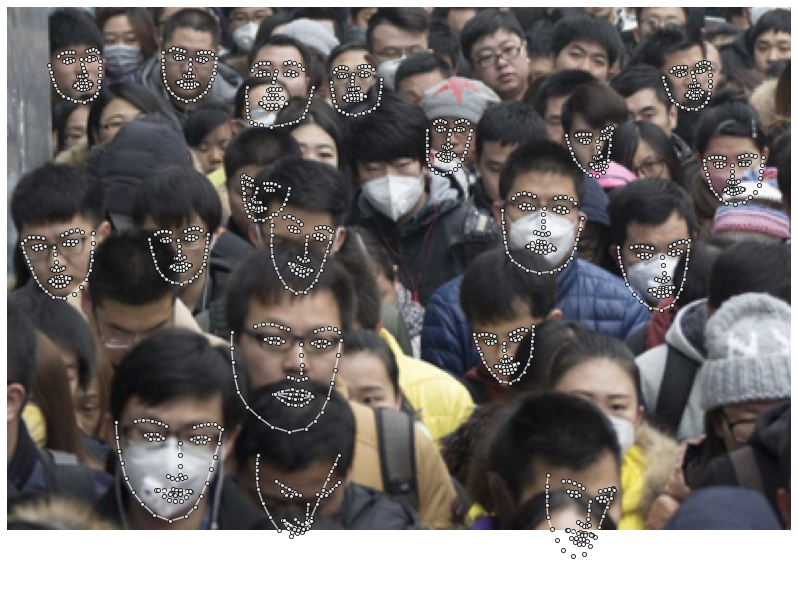

In [44]:
exemplary_imgs = [cv.imread(file) for file in exemplary_imgs_files]
fig=plt.figure(figsize=(30, 15))
axes = []
dense_flag = False

for i in range(len(exemplary_imgs)):
    img = exemplary_imgs[i]
    boxes = face_boxes(img)
    param_lst, roi_box_lst = tddfa(img, boxes)
    ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
    draw_landmarks(img, ver_lst, dense_flag=dense_flag)

In [ ]:
def get_3ddfa_results(detector, img):
    faces = detector(img)
    return len(faces)

## Detector 6 - CrowdHuman

In [42]:
%%bash
cd yolov4_crowdhuman/darknet
 ./darknet detector test data/crowdhuman-608x608.data \
                          cfg/yolov4-crowdhuman-608x608.cfg \
                          backup/yolov4-crowdhuman-608x608_best.weights \
                          -dont_show -ext_output < ../../dataset/trial/filenames.txt > ../../dataset/trial/result.txt \
                          -out ../../dataset/trial/result.json \
                          -gpus 0

 CUDA-version: 11020 (11020), cuDNN: 8.1.0, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: GeForce RTX 2070 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   9 route  8 2 	                           ->  304 x 304 x 128 
  

In [43]:
import json
with open("dataset/trial/result.json") as file:
    data = json.load(file)

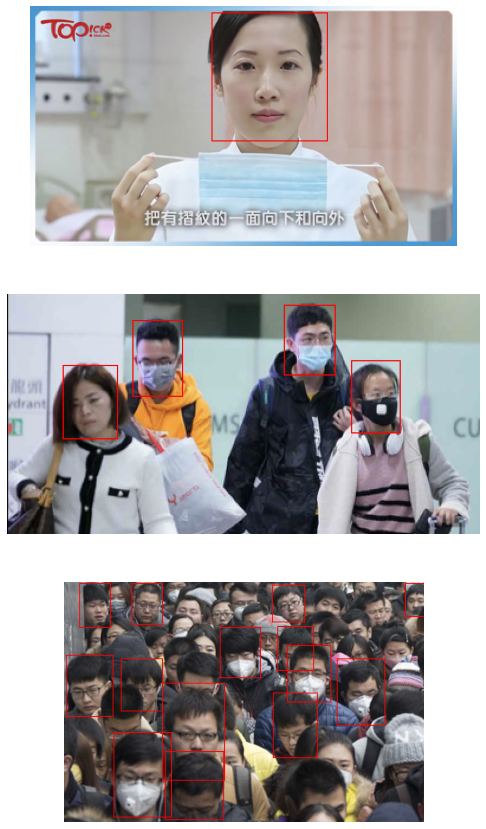

In [44]:
fig=plt.figure(figsize=(30, 15))
axes = []
i = 0

for photo in data:
    img = cv.imread(photo["filename"])
    width = img.shape[1]
    height = img.shape[0]
    for object in photo["objects"]:
        if object["name"] == 'head' and object["confidence"] > 0.5 :
            xmin = int((object["relative_coordinates"]["center_x"] - object["relative_coordinates"]["width"]/2)*width)
            xmax = int((object["relative_coordinates"]["center_x"] + object["relative_coordinates"]["width"]/2)*width)
            ymin = int((object["relative_coordinates"]["center_y"] - object["relative_coordinates"]["height"]/2)*height)
            ymax = int((object["relative_coordinates"]["center_y"] + object["relative_coordinates"]["height"]/2)*height)
            cv.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 1)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(3, 1, i+1))
    plt.axis('off')
    plt.imshow(img)
    i += 1